In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as imb_pipeline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
train_data = pd.read_csv('data/CreditCard_Fraud_Detection/train.csv')
test_data = pd.read_csv('data/CreditCard_Fraud_Detection/test.csv')
val_data = pd.read_csv('data/CreditCard_Fraud_Detection/val.csv')
train_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,119191.0,2.052427,-0.133236,-1.740621,0.277935,0.337999,-0.826933,0.334629,-0.227039,0.267655,...,-0.006518,0.121300,0.037733,-0.356498,0.147822,0.569149,-0.103929,-0.091958,8.73,0
1,71750.0,1.220356,-0.159191,-0.444349,-0.094437,0.104457,-0.345790,0.170867,-0.094996,0.187572,...,-0.088775,-0.364654,-0.140851,-0.707308,0.415661,1.087767,-0.102532,-0.008335,59.95,0
2,151977.0,0.892824,-1.440698,-0.637940,3.912871,0.099291,2.433288,-0.308891,0.603227,-0.113826,...,0.484969,0.487304,-0.122694,-0.598803,-0.594563,0.062841,-0.033426,0.038254,460.65,0
3,55709.0,-3.146021,2.247634,0.901397,0.146162,-2.109360,-0.148312,-1.533191,2.073663,0.499394,...,0.050567,-0.037019,0.107000,0.392857,0.303597,0.379544,-0.148990,0.074965,4.78,0
4,66654.0,1.194996,-0.007495,0.301285,0.750199,-0.297494,-0.405836,0.060410,-0.150482,0.400860,...,-0.234931,-0.545566,-0.089418,-0.064036,0.527305,0.294221,-0.025980,0.015637,44.31,0


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170884 entries, 0 to 170883
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    170884 non-null  float64
 1   V1      170884 non-null  float64
 2   V2      170884 non-null  float64
 3   V3      170884 non-null  float64
 4   V4      170884 non-null  float64
 5   V5      170884 non-null  float64
 6   V6      170884 non-null  float64
 7   V7      170884 non-null  float64
 8   V8      170884 non-null  float64
 9   V9      170884 non-null  float64
 10  V10     170884 non-null  float64
 11  V11     170884 non-null  float64
 12  V12     170884 non-null  float64
 13  V13     170884 non-null  float64
 14  V14     170884 non-null  float64
 15  V15     170884 non-null  float64
 16  V16     170884 non-null  float64
 17  V17     170884 non-null  float64
 18  V18     170884 non-null  float64
 19  V19     170884 non-null  float64
 20  V20     170884 non-null  float64
 21  V21     17

### Checking for null values

In [4]:
train_data.isnull().values.any()

False

### Checking if there's data imbalance

Class
0    170579
1       305
Name: count, dtype: int64


Text(0, 0.5, 'Frequency')

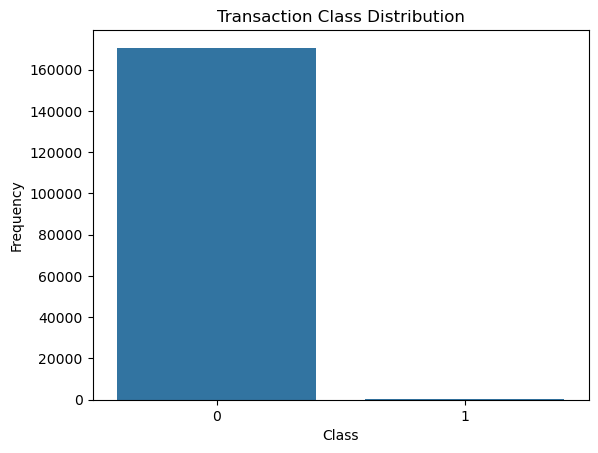

In [5]:
print(train_data['Class'].value_counts())

sns.countplot(data=train_data, x='Class')
plt.title('Transaction Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

### Let's review the distributions for columns

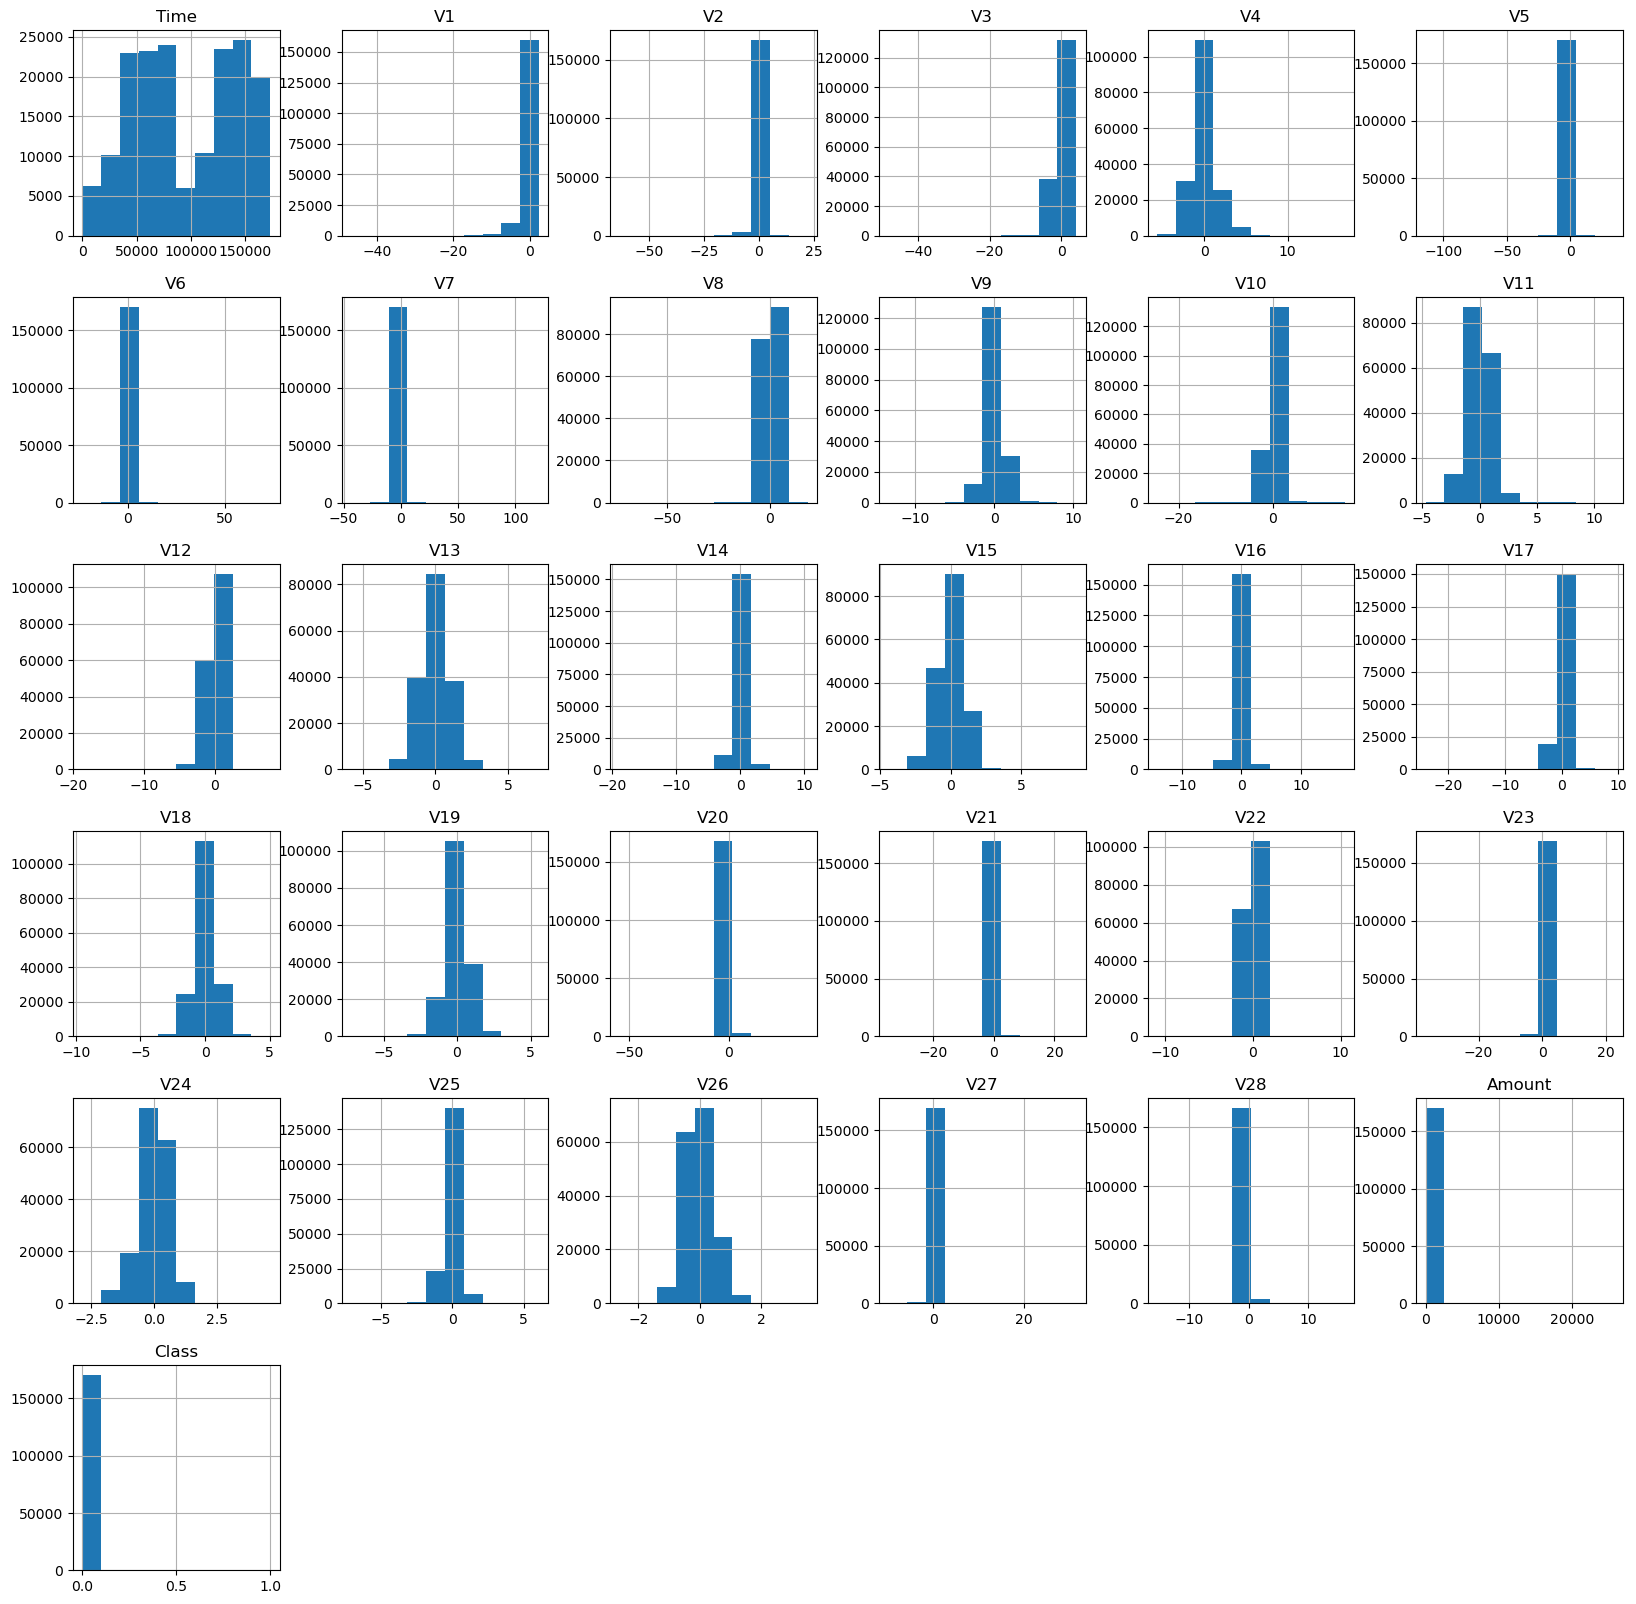

In [6]:
train_data.hist(figsize=(20, 20));

#### All columns are normalized except for `Amount` And `Time`
#### So, we need to normalize them

In [7]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(train_data['Amount'].to_numpy().reshape(-1, 1))

train_data['Amount'] = rs.transform(train_data['Amount'].to_numpy().reshape(-1, 1))
val_data['Amount'] = rs.transform(val_data['Amount'].to_numpy().reshape(-1, 1))
test_data['Amount'] = rs.transform(test_data['Amount'].to_numpy().reshape(-1, 1))

# Compute mean, and standard deviation
train_mu = train_data['Time'].mean()
train_sigma = train_data['Time'].std()

train_data['Time'] = (train_data['Time'] - train_mu) / train_sigma
val_data['Time'] = (val_data['Time'] - train_mu) / train_sigma
test_data['Time'] = (test_data['Time'] - train_mu) / train_sigma

#### Now, review the data again

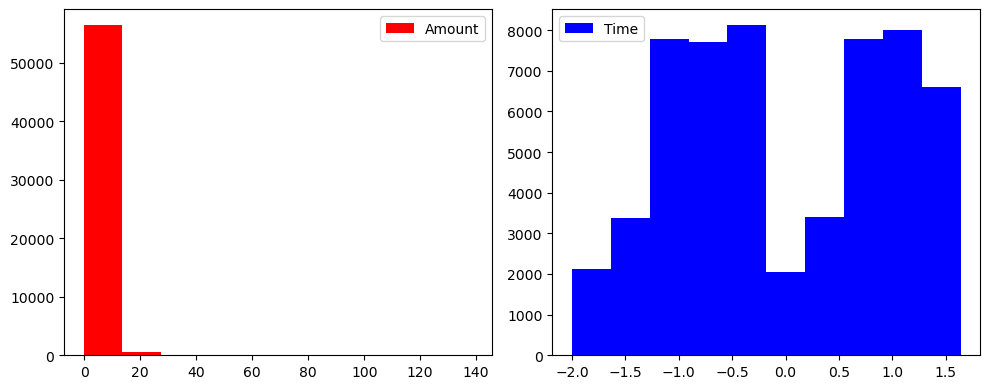

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(data=test_data, x='Amount', color='red', label='Amount')
axes[0].legend()


axes[1].hist(data=test_data, x='Time', color='blue', label='Time')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
X_train = train_data.drop(columns='Class')
y_train = train_data['Class']

X_val = val_data.drop(columns='Class')
y_val = val_data['Class']

X_test = test_data.drop(columns='Class')
y_test = test_data['Class']

# We'll train several models with/without sampling and choose the best berforming one

### Logistic Regression (Without Sampling)

########## Logistic Regression (without sampling) ##########

Acc.: 0.9993328651685394

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.91      0.64      0.75        90

    accuracy                           1.00     56960
   macro avg       0.95      0.82      0.88     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56864     6]
 [   32    58]]
PR-AUC: 0.7662809948437669


/Users/magedtarak/pytorch-test/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


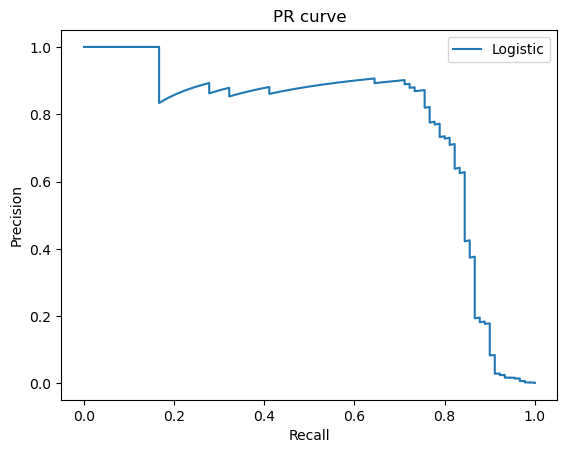

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_scores = lr.predict_proba(X_val)[:, 1]


print('########## Logistic Regression (without sampling) ##########\n')

print('Acc.:', lr.score(X_val, y_val))

print('\nclassification report:')
print(classification_report(y_val, lr.predict(X_val), target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val, lr.predict(X_val)))


precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

pr_auc = auc(recall, precision)
print('PR-AUC:', pr_auc)

plt.plot(recall, precision, label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()
plt.show()

### Random Forest Classifier (Without Sampling)

########## Random Forest Classifier (without sampling) ##########
Acc.: 0.9995786516853933

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.96      0.77      0.85        90

    accuracy                           1.00     56960
   macro avg       0.98      0.88      0.93     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56867     3]
 [   21    69]]
PR-AUC: 0.8603144662117843


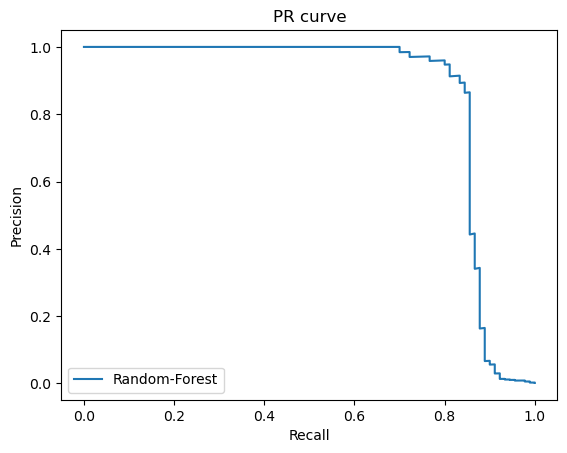

In [11]:
rfc = RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
y_scores = rfc.predict_proba(X_val)[:, 1]


print('########## Random Forest Classifier (without sampling) ##########')
print('Acc.:', rfc.score(X_val, y_val))

print('\nclassification report:')
print(classification_report(y_val, rfc.predict(X_val), target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val, rfc.predict(X_val)))

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

pr_auc = auc(recall, precision)
print('PR-AUC:', pr_auc)

plt.plot(recall, precision, label='Random-Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()
plt.show()

### Train Using Neural Network

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.tensor(self.X.iloc[idx]), torch.tensor(self.y.iloc[idx])

    def __len__(self):
        return len(self.y)

train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=512,
                          shuffle=True,
                          drop_last=True)

val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=512)

class NN_MODEL(nn.Module):
    def __init__(self, num_features, hidden_layer1, num_classes):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(num_features, hidden_layer1),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm1d(hidden_layer1),
                                 # nn.Linear(hidden_layer1, hidden_layer2),
                                 # nn.ReLU(inplace=True),
                                 # nn.BatchNorm1d(hidden_layer2),
                                 nn.Linear(hidden_layer1, num_classes))
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    module.bias.detach().zero_()

    def forward(self, x):
        return self.net(x)

model = NN_MODEL(num_features=X_train.shape[1],
                 hidden_layer1=100,
                 # hidden_layer2=100,
                 num_classes=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
cnt = 0
for p in model.parameters():
    cnt += p.numel()

print(f'No. of model parameters: {cnt:_}')

No. of model parameters: 3_502


In [14]:
def compute_accuracy(y_true, y_pred):
    accuracy = torch.sum(y_true.view(-1).float() == 
                         y_pred.float()).item() / y_true.size(0)
    return accuracy

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0
    
    for idx, (x, y) in enumerate(train_loader):
        x = x.float()
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    print(f'Epoch: {epoch + 1}/{num_epochs} | '
          f'Training Loss: {(running_loss / total_samples):.4f}')

    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    for idx, (x, y) in enumerate(val_loader):
        x = x.float()
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    print(f'Epoch: {epoch + 1}/{num_epochs} | '
          # f'Acc.: {running_acc:.4f} | '
          f'Validation Loss: {(running_loss / total_samples):.4f}')
        

Epoch: 1/5 | Training Loss: 0.1500
Epoch: 1/5 | Validation Loss: 0.0061
Epoch: 2/5 | Training Loss: 0.0040
Epoch: 2/5 | Validation Loss: 0.0033
Epoch: 3/5 | Training Loss: 0.0032
Epoch: 3/5 | Validation Loss: 0.0029
Epoch: 4/5 | Training Loss: 0.0030
Epoch: 4/5 | Validation Loss: 0.0035
Epoch: 5/5 | Training Loss: 0.0028
Epoch: 5/5 | Validation Loss: 0.0023


In [15]:
X_val_np = torch.tensor(X_val.to_numpy()).float()
y_val_np = torch.tensor(y_val.to_numpy()).float()
probas = F.softmax(model(X_val_np))

y_preds = (probas >= 0.5).float()

preds = []
for p in y_preds:
    if p[0] == 1:
        preds.append(0)
    else:
        preds.append(1)

print('########## Neural Network (without sampling) ##########')
print('Acc.:', (preds == y_val_np.numpy()).sum() / y_val_np.shape[0])
print('\nclassification report:')
print(classification_report(y_val_np, preds, target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val_np, preds))

/var/folders/v4/wjwbr7sx5zg0r1dwhqg7tgt40000gn/T/ipykernel_10427/1363543049.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(model(X_val_np))


########## Neural Network (without sampling) ##########
Acc.: 0.9995259831460674

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.90      0.79      0.84        90

    accuracy                           1.00     56960
   macro avg       0.95      0.89      0.92     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56862     8]
 [   19    71]]


In [16]:
def under_sample(X, y):
    counter = Counter(y)
    print(counter)

    factor, minority_size = 2, counter[1]
    rus = RandomUnderSampler(sampling_strategy={1: factor * minority_size}, random_state=42)
    X_us, y_us = rus.fit_resample(X, y)
    print(Counter(y_us))
    
    return X_us, y_us

In [17]:
counter = Counter(y_train)

rus = RandomUnderSampler(sampling_strategy={0: 100 * counter[1]}, random_state=42)
X_us, y_us = rus.fit_resample(X_train, y_train)
print(Counter(y_us))

Counter({0: 30500, 1: 305})


########## Logistic Regression (without sampling) ##########

Acc.: 0.9992977528089888

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.78      0.77      0.78        90

    accuracy                           1.00     56960
   macro avg       0.89      0.88      0.89     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56851    19]
 [   21    69]]
PR-AUC: 0.7264130555686115


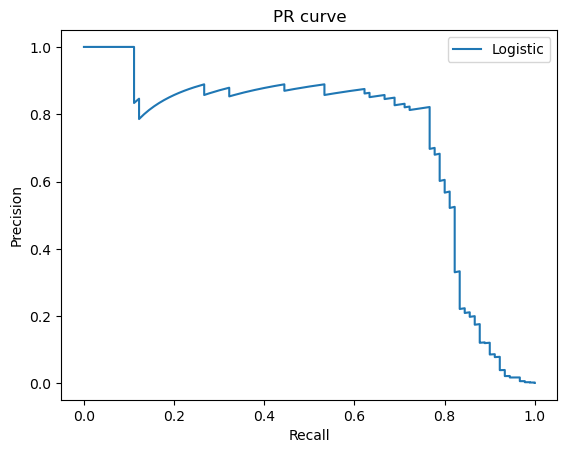

In [18]:
lr = LogisticRegression()
lr.fit(X_us, y_us)
y_scores = lr.predict_proba(X_val)[:, 1]

print('########## Logistic Regression (without sampling) ##########\n')

print('Acc.:', lr.score(X_val, y_val))

print('\nclassification report:')
print(classification_report(y_val, lr.predict(X_val), target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val, lr.predict(X_val)))

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
pr_auc = auc(recall, precision)
print('PR-AUC:', pr_auc)

plt.plot(recall, precision, label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()
plt.show()

########## Random Forest Classifier (Under sampling) ##########
Acc.: 0.999561095505618

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.89      0.82      0.86        90

    accuracy                           1.00     56960
   macro avg       0.95      0.91      0.93     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56861     9]
 [   16    74]]
PR-AUC: 0.8498941187524642


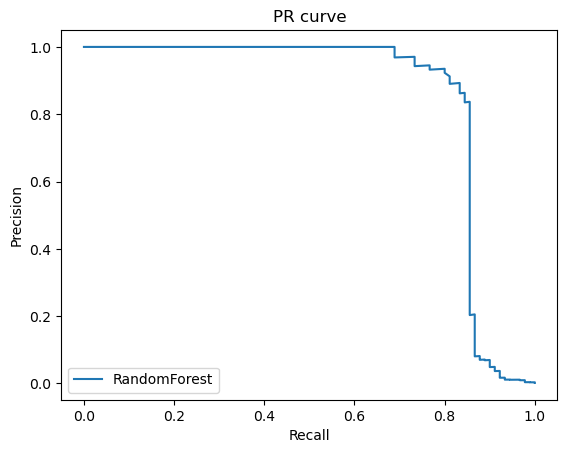

In [19]:
rfc_us = RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1)
rfc_us.fit(X_us, y_us)
y_scores = rfc_us.predict_proba(X_val)[:, 1]

print('########## Random Forest Classifier (Under sampling) ##########')
print('Acc.:', rfc_us.score(X_val, y_val))

print('\nclassification report:')
print(classification_report(y_val, rfc_us.predict(X_val), target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val, rfc_us.predict(X_val)))

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
pr_auc = auc(recall, precision)
print('PR-AUC:', pr_auc)

plt.plot(recall, precision, label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()
plt.show()

In [20]:
train_dataset_us = MyDataset(X_us, y_us)
train_loader_us = DataLoader(dataset=train_dataset_us,
                              batch_size=512,
                              shuffle=True,
                              drop_last=True)

class NN_MODEL(nn.Module):
    def __init__(self, num_features, hidden_layer1, num_classes):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(num_features, hidden_layer1),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm1d(hidden_layer1),
                                 # nn.Linear(hidden_layer1, hidden_layer2),
                                 # nn.ReLU(inplace=True),
                                 # nn.BatchNorm1d(hidden_layer2),
                                 nn.Linear(hidden_layer1, num_classes))
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    module.bias.detach().zero_()

    def forward(self, x):
        return self.net(x)

model_us = NN_MODEL(num_features=X_us.shape[1],
                 hidden_layer1=100,
                 # hidden_layer2=100,
                 num_classes=2)

optimizer = optim.Adam(model_us.parameters(), lr=0.05)

def compute_accuracy(y_true, y_pred):
    accuracy = torch.sum(y_true.view(-1).float() == 
                         y_pred.float()).item() / y_true.size(0)
    return accuracy

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0
    
    for idx, (x, y) in enumerate(train_loader_us):
        x = x.float()
        optimizer.zero_grad()
        logits = model_us(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    print(f'Epoch: {epoch + 1}/{num_epochs} | '
          f'Training Loss: {(running_loss / total_samples):.4f}')

    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    for idx, (x, y) in enumerate(val_loader):
        x = x.float()
        optimizer.zero_grad()
        logits = model_us(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    print(f'Epoch: {epoch + 1}/{num_epochs} | '
          # f'Acc.: {running_acc:.4f} | '
          f'Validation Loss: {(running_loss / total_samples):.4f}')

Epoch: 1/5 | Training Loss: 0.0754
Epoch: 1/5 | Validation Loss: 0.0057
Epoch: 2/5 | Training Loss: 0.0150
Epoch: 2/5 | Validation Loss: 0.0039
Epoch: 3/5 | Training Loss: 0.0135
Epoch: 3/5 | Validation Loss: 0.0034
Epoch: 4/5 | Training Loss: 0.0123
Epoch: 4/5 | Validation Loss: 0.0042
Epoch: 5/5 | Training Loss: 0.0126
Epoch: 5/5 | Validation Loss: 0.0036


In [21]:
probas = F.softmax(model_us(X_val_np))

y_preds = (probas >= 0.5).float()

preds = []
for p in y_preds:
    if p[0] == 1:
        preds.append(0)
    else:
        preds.append(1)

print('########## Neural Network (Under sampling) ##########')
print('Acc.:', (preds == y_val_np.numpy()).sum() / y_val_np.shape[0])
print('\nclassification report:')
print(classification_report(y_val_np, preds, target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_val_np, preds))

/var/folders/v4/wjwbr7sx5zg0r1dwhqg7tgt40000gn/T/ipykernel_10427/246408374.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(model_us(X_val_np))


########## Neural Network (Under sampling) ##########
Acc.: 0.9995435393258427

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56870
          TP       0.91      0.79      0.85        90

    accuracy                           1.00     56960
   macro avg       0.95      0.89      0.92     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56863     7]
 [   19    71]]


### From the results above we can see that Random Forest Classifier (Without sampling) performs the best, so let's test it on testing data

########## Random Forest Classifier (Without sampling) ##########
Acc.: 0.9995084269662922

classification report:
              precision    recall  f1-score   support

          TN       1.00      1.00      1.00     56863
          TP       0.90      0.80      0.85        97

    accuracy                           1.00     56960
   macro avg       0.95      0.90      0.92     56960
weighted avg       1.00      1.00      1.00     56960


confusion matrix:
[[56854     9]
 [   19    78]]
PR-AUC: 0.8411149462142679


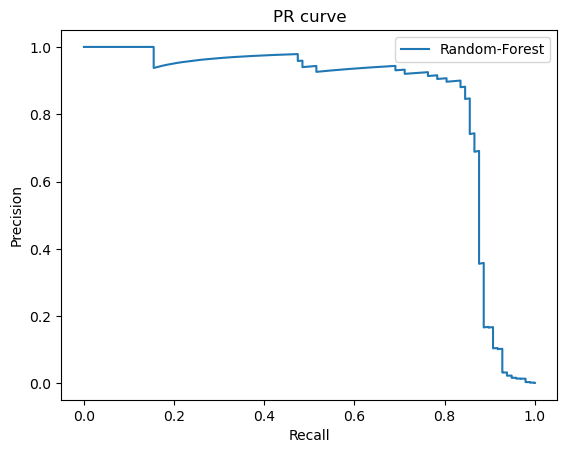

In [22]:
y_scores = rfc.predict_proba(X_test)[:, 1]

print('########## Random Forest Classifier (Without sampling) ##########')
print('Acc.:', rfc.score(X_test, y_test))

print('\nclassification report:')
print(classification_report(y_test, rfc.predict(X_test), target_names=['TN', 'TP']))

print('\nconfusion matrix:')
print(confusion_matrix(y_test, rfc.predict(X_test)))

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

pr_auc = auc(recall, precision)
print('PR-AUC:', pr_auc)

plt.plot(recall, precision, label='Random-Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()
plt.show()